# Dataset

In [4]:
import pandas as pd

In [103]:
nodes=pd.read_csv('data/nodes.csv')
links=pd.read_csv('data/links.csv')


In [27]:
def vt2benignMal(flags):
        if flags>=10:
            return 1
        elif flags==0:
            return 0
        else:
            return -1
MALWARE_FLAG=10
malNodes=nodes[nodes.vt_5>=MALWARE_FLAG]
greyNodes=nodes[nodes.vt_5.apply(lambda x: MALWARE_FLAG>x>0)]
benignNodes=nodes[nodes.vt_5==0]

links_vt=links.dropna()
links_vt['dst_mal']=links_vt.vt_5.apply(vt2benignMal)
maldstLinks=links_vt[links_vt.dst_mal==1]
benigndstLinks=links_vt[links_vt.dst_mal==0]
greydstLinks=links_vt[links_vt.dst_mal==-1]



text=f'''In total, our constructed app promotion graph consists of {nodes.shape[0]} apps, including
 {malNodes.shape[0]} malware, {greyNodes.shape[0]} PUAs, and {benignNodes.shape[0]} benign apps.
 Note that the total number of apps {nodes.shape[0]} is not a sum of the number of apps
({nodes[~nodes.vt_5.isna()].shape[0]}) in the malware, PUA, and benign classes. This discrepancy
is due to some promoted apps not being archived in AndroZoo at
the time of our analysis, which we will further elaborate in Section
5.4. From these apps, our technique collects {len(links)} instances
of app promotion ads. In particular, {maldstLinks.shape[0]/links.shape[0]+greydstLinks.shape[0]/len(links)}% of the ads are linked to
malware ({maldstLinks.shape[0]}) and PUAs ({greydstLinks.shape[0]}), while the remaining ads are tied
to benign apps ({benigndstLinks.shape[0]}). '''

print(text)

In total, our constructed app promotion graph consists of 6008 apps, including
 464 malware, 1042 PUAs, and 3961 benign apps.
 Note that the total number of apps 6008 is not a sum of the number of apps
(5467) in the malware, PUA, and benign classes. This discrepancy
is due to some promoted apps not being archived in AndroZoo at
the time of our analysis, which we will further elaborate in Section
5.4. From these apps, our technique collects 18627 instances
of app promotion ads. In particular, 0.2220432705212863% of the ads are linked to
malware (520) and PUAs (3616), while the remaining ads are tied
to benign apps (13054). 


/var/folders/p0/ryz91jfn37x9b1q45qzfvrxr0000gn/T/ipykernel_45599/3525297665.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links_vt['dst_mal']=links_vt.vt_5.apply(vt2benignMal)


# RQ1

In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [23]:
# Load the additional CSV files
file_paths=[
            'data/ADGPE(dfs).csv',
            'data/ADGPE(bfs).csv',
            'data/droidbot.csv',
            'data/monkey.csv']

# Create a list to store dataframes
dataframes = []
pkg_names=pd.read_csv('data/labeled_ad_unit.csv')['pkg_name'].tolist()
# Function to process and accumulate ad counts
def process_data(file_path):
    data = pd.read_csv(file_path)
    data=data[data.pkg_name.isin(pkg_names)]
    data['ad'] = data['ad'].str.replace("Broadcasting: Intent { act=clipper.get flg=0x400000 }\nBroadcast completed: result=0, data=", "", regex=True)
    data['ad_count'] = data['ad'].apply(lambda x: len(list(set(eval(x)))) if x != '[]' else 0)
    grouped_data = data.groupby('time')['ad_count'].sum().reset_index()
    filtered_data = grouped_data[grouped_data['ad_count'] > 0]
    filtered_data['accumulated_ad_count'] = filtered_data['ad_count'].cumsum()
    return filtered_data

# Process each file and store the processed data
for path in file_paths:
    dataframes.append(process_data(path))





def extract_name_from_filename(filename):
    # Using regex to find the pattern after the time in the filename
    match = re.search(r'_(\d{4}\.\d{2}\.\d{2}-\d{2}\.\d{2}\.\d{2})_(.*)\.csv', filename)
    if match:
        return match.group(2)
    else:
        return "Unknown"


names=['ADGPE','ADGPE(bfs)','Droidbot','Monkey']



In [29]:
given_timestamps = [10000,20000,30000,40000,50000,60000,70000]
ad_efficiency_df={'ADGPE':[],'ADGPE(bfs)':[],'Droidbot':[],'Monkey':[]}
for given_timstamp in given_timestamps:
# Find the row with the closest time to the given timestamp
    for name,df in zip(names,dataframes):
        # if name=='ADGPE':
            # base=df.iloc[(df['time'] - given_timstamp).abs().argmin(),2]
        value=df.iloc[(df['time'] - given_timstamp).abs().argmin(),2]
        ad_efficiency_df[name].append(value)

pd.DataFrame(ad_efficiency_df)

,ADGPE,ADGPE(bfs),Droidbot,Monkey
0,20,17,13,11
1,47,41,32,22
2,74,60,45,35
3,88,72,61,55
4,108,89,69,70
5,122,114,83,88
6,137,130,96,97


In [20]:
given_timestamps = [10000,20000,30000,40000,50000,60000,70000]
ad_efficiency_df={'ADGPE':[],'ADGPE(bfs)':[],'Droidbot':[],'Monkey':[]}
for given_timstamp in given_timestamps:
# Find the row with the closest time to the given timestamp
    for name,df in zip(names,dataframes):
        if name=='ADGPE':
            base=df.iloc[(df['time'] - given_timstamp).abs().argmin(),2]
        value=df.iloc[(df['time'] - given_timstamp).abs().argmin(),2]
        ad_efficiency_df[name].append(100*(base-value)/base+100)
pd.DataFrame(ad_efficiency_df)

,ADGPE,ADGPE(bfs),Droidbot,Monkey
0,100.0,115.000000,135.000000,145.000000
1,100.0,112.765957,131.914894,153.191489
2,100.0,118.918919,139.189189,152.702703
3,100.0,118.181818,130.681818,137.500000
4,100.0,117.592593,136.111111,135.185185
5,100.0,106.557377,131.967213,127.868852
6,100.0,105.109489,129.927007,129.197080


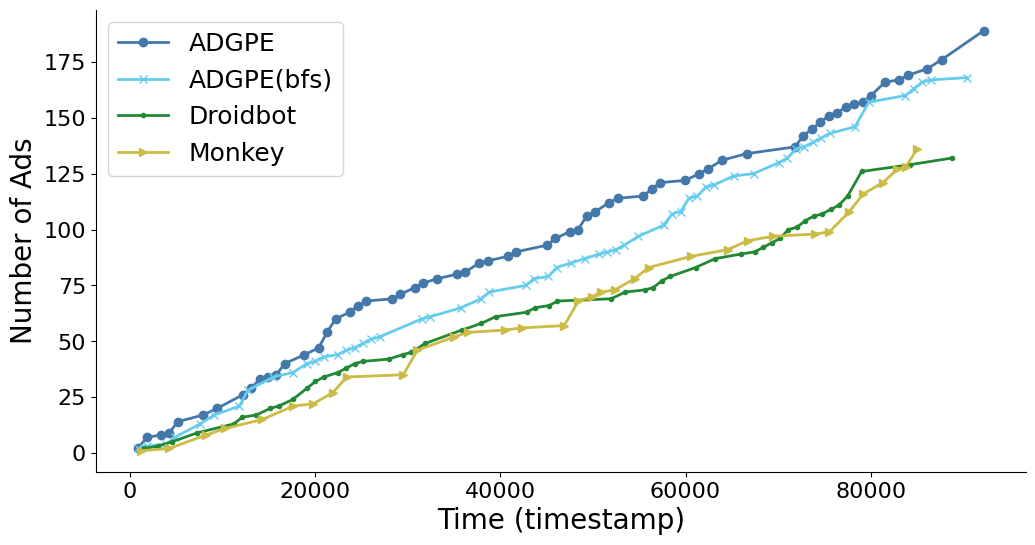

In [5]:
# Re-plotting all the dataframes with appropriate legend names
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.figure(figsize=(12, 6))
from itertools import cycle
colors = cycle(plt.cm.tab10.colors)
# Plot for the original data
# plt.plot(filtered_data['time'], filtered_data['accumulated_ad_count'], marker='o', linestyle='-', label='Original Data')

# Plot for the new data with extracted names
# names=['']
markers=['o','x','.','>']
colors=['#4477AA','#66CCEE','#228833','#CCBB44']
for i, df in enumerate(dataframes):
    plt.plot(df['time'], df['accumulated_ad_count'], marker=markers[i], linestyle='-', color=colors[i], label=names[i],markersize=6, linewidth=2)
    
# names=['bfs','dfs']
# for i, df in enumerate([merged_bfs,merged_dfs]):
#     plt.plot(df['time'], df['mean_accumulated_ad_count'], marker='x', linestyle='-', color=next(colors), label=names[i])
# plt.title('Comparison of Accumulated Ads Detected Over Time',fontsize=14)
plt.xlabel('Time (timestamp)', fontsize=20)
plt.ylabel('Number of Ads',fontsize=20)
# plt.xlim(0,80000)
# plt.ylim(0,200)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.savefig('../timeEfficiency.pdf',format='pdf',dpi=600,bbox_inches="tight")
# plt.grid(True)
plt.show()


'labeled_ad_unit.csv' and 'labeled_ad_format.csv' both include the 100 benchamark apps. 

They have the groundtruth and the output of the UI exploration techniques confirmed by our manual examination.

Ad units

In [33]:
df=pd.read_csv('data/labeled_ad_unit.csv')
df.fillna(0,inplace=True)
df.columns=['pkg_name', 'sha', 'ad', 'num_ad', 'Manual Examination', 'ADGPE(bfs)', 'ADGPE', 'Droidbot','Monkey']
for i in ['Manual Examination', 'ADGPE(bfs)', 'ADGPE', 'Droidbot','Monkey']:
    print(f'{i} : {sum(df[i])}')

Manual Examination : 239
ADGPE(bfs) : 131
ADGPE : 165
Droidbot : 76
Monkey : 71.0


Ad formats

In [34]:
df=pd.read_csv('data/100_having_ads - ad format.csv')
df.columns=['pkg_name', 'ad', 'num_ad','Manual Examination', 'ADGPE(bfs)', 'ADGPE', 'Droidbot','Monkey']


def count_category_appearances(column):
    category_counts = {}
    for ad_list in df[column].dropna():
        for ad in ad_list.split(','):
            ad = ad.strip()
            if ad in category_counts:
                category_counts[ad] += 1
            else:
                category_counts[ad] = 1
    return category_counts

columns_to_check = ['Manual Examination', 'ADGPE(bfs)', 'ADGPE', 'Droidbot','Monkey']
category_appearances = {column: count_category_appearances(column) for column in columns_to_check}

In [35]:

comparison_df = pd.DataFrame.from_dict(category_appearances, orient='index')
comparison_df = comparison_df.fillna(0).astype(int)  # Fill NaN with 0 and convert to integers
comparison_df = comparison_df.transpose()  # Transpose to get the desired format

# Display the DataFrame
comparison_df


,Manual Examination,ADGPE(bfs),ADGPE,Droidbot,Monkey
banner,69,45,65,25,21
native,20,7,11,2,5
intersititial,66,50,60,36,31
appwall,45,15,17,9,11
exit,20,8,4,0,2
open,3,3,3,2,1
rewarded,2,0,1,0,0


In [36]:
comparison_df = pd.DataFrame.from_dict(category_appearances, orient='index').fillna(0).astype(int).transpose()

combined_categories = {
    'inherent': ['banner', 'native'],
    'pop up': ['intersititial'],
    'appwall':['appwall'],
    'others': ['rewarded', 'exit', 'open']
}


updated_comparison_df = pd.DataFrame(index=comparison_df.columns)

for new_category, old_categories in combined_categories.items():

    updated_comparison_df[new_category] = 0

    for old_category in old_categories:
        if old_category in comparison_df.index:
            updated_comparison_df[new_category] += comparison_df.loc[old_category]


updated_comparison_df = updated_comparison_df.transpose()


display(updated_comparison_df)

,Manual Examination,ADGPE(bfs),ADGPE,Droidbot,Monkey
inherent,89,52,76,27,26
pop up,66,50,60,36,31
appwall,45,15,17,9,11
others,25,11,8,2,3


# RQ2

In [8]:
import pandas as pd
import networkx as nx


## Table 4

In [12]:
nodes=pd.read_csv('data/nodes.csv')
links=pd.read_csv('data/links.csv')

In [9]:
 G=nx.from_pandas_edgelist(links,source='package_src',target='package_dst',create_using=nx.DiGraph())


In [10]:
path_lengths=nx.all_pairs_shortest_path_length(G)
path_lengths=dict(path_lengths)

In [20]:
malware_flag=10
# b represents benign, g represents pua, m represents malware
pathDict={'b-g':[],'b-m':[],'b-b':[],'g-g':[],'g-b':[],'g-m':[],'m-b':[],'m-m':[],'m-g':[]}
hops_acc={i:[] for i in range(1,6)}
def bgm(vt,flag):
    if vt>=flag:
        return 'm'
    elif vt==0:
        return 'b'
    else:
        return 'g'
for src,dsts in path_lengths.items():
    for dst,length in dsts.items():
        if length==0:
            continue
        src_vt=nodes[nodes.pkg_name==src].iloc[0,3]
        dst_vt=nodes[nodes.pkg_name==dst].iloc[0,3]
        src_mal=bgm(src_vt,malware_flag)
        dst_mal=bgm(dst_vt,malware_flag)
        pathDict[src_mal+'-'+dst_mal].append(length)
        for l in hops_acc.keys():
            if l>=length:
                hops_acc[l].append(src_mal+dst_mal)

In [34]:
elementTables=[]
for key,val in hops_acc.items():
    # print('hop: ',key)
    elementTable={0:[0,0,0],1:[0,0,0],2:[0,0,0]}
    countTable=pd.Series(val).value_counts()
    mapping={'b':0,'g':1,'m':2}
    for i in countTable.index:
        elementTable[mapping[i[0]]][mapping[i[1]]]=countTable[i]
    elementTable=pd.DataFrame(elementTable)
    elementTables.append(elementTable)
    pd.concat(elementTables,axis=1)


Left part of Table 4 is shown below

In [22]:
pd.concat(elementTables,axis=0)


,0,1,2
0,8206,3052,1796
1,2997,1320,736
2,111,355,54
0,14735,10046,2918
1,5248,3656,1133
2,181,484,80
0,20686,15089,4250
1,7276,5685,1601
2,216,500,89
0,26407,18384,5501


In [33]:
import numpy as np
import warnings
warnings.simplefilter('ignore')

Right part of Table 4

In [35]:
transposedPercentTables=[]
for tab in elementTables:

    e=tab
    total=np.sum(e)
    for col in e.columns:
        e[col]=e[col].apply(lambda x: '%.2f'%(x/total[col]*100))
    transposedPercentTables.append(e)
pd.concat(transposedPercentTables,axis=0)

,0,1,2
0,72.53,64.57,69.45
1,26.49,27.92,28.46
2,0.98,7.51,2.09
0,73.08,70.82,70.64
1,26.03,25.77,27.43
2,0.90,3.41,1.94
0,73.41,70.93,71.55
1,25.82,26.72,26.95
2,0.77,2.35,1.50
0,74.19,71.50,73.35


## Case Study

In [36]:
nodes_all=pd.read_csv('data/node_all_attributes.csv')

In [40]:
nodes_all['engines']=nodes_all['engines'].fillna(' ')

In [41]:
malware_PUA=nodes_all[nodes_all.vt_5>0]
adware=malware_PUA[malware_PUA['engines'].apply(lambda x: 'adware' in x or 'hiddenad' in x)]
trojan=malware_PUA[malware_PUA['engines'].apply(lambda x: 'trojan' in x)]

In [43]:
print(f'Aggressive Adware precent is {len(adware)/len(malware_PUA)*100}')
print(f'Trojan precent is {len(trojan)/len(malware_PUA)*100}')


Aggressive Adware precent is 32.005312084993356
Trojan precent is 53.253652058432934


lomol apps

In [70]:
nodes_all['developer']=nodes_all['developer'].fillna(' ')
lomol_df=nodes_all[nodes_all.pkg_name.apply(lambda x:'com.lomolsoft' in x )]
lomol_dev_df=nodes_all[nodes_all.developer.apply(lambda x:'lomol' in x )]
lomol_df=pd.concat([lomol_df,lomol_dev_df],axis=0).drop_duplicates('pkg_name')

In [71]:
display(lomol_df.shape)
display(lomol_df.head())

(93, 16)

,pkg_name,app_name,developer,star,review,download,rating,update_date,description,app_type,size,engines,sha,androguard,vt_5,vt_detection
694,com.lomolsoft.learn.swedishdict,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19573312,trojan.androidos.linux.c!c android.malware.gen...,C5DE22B9B19B65967CA63DFF33B8F8BC1702CFEDD0C899...,{'Activities': ['com.lomolsoft.learn.swedishdi...,14.0,"[14.0, 5.0]"
2732,com.lomolsoft.net.entltranslation,Filipino English Translation,lomol translator,NaN,NaN,500+,Everyone,"May 6, 2023",English-Filipino translation is a fast transla...,Books & Reference,6808957,elf.trojan.a3184698 artemis!6f0f62a3ece3 andro...,749F7146420DFC5D1337740EAEC90778C3AE2570394273...,"{'VTAndroidInfo': 2.0, 'AndroidApplicationErro...",10.0,[10.0]
2738,com.lomolsoft.net.enfrtranslation,French English Translation,lomol translator,NaN,NaN,1K+,Everyone,"May 6, 2023",English-French translation is a fast translati...,Books & Reference,5781897,trojan.ewind.android.782 android.malware.gener...,96CB08452B7F3C9ACCFCAE164DEB648A34B45095228DDF...,"{'VTAndroidInfo': 1.41, 'AndroidApplicationErr...",7.0,[7.0]
2862,com.lomolsoft.net.cnjatranslation,Japanese Chinese Translation,lomol translator,NaN,NaN,10K+,Everyone,"May 6, 2023",Chinese-Japanese Translation is a fast transla...,Books & Reference,6731136,trojan ( 0053576b1 ) androidos/trojan.ytkp-0 a...,FBE493E05A7A7B748720E676FF9ED882D8A39D8D8BA2AD...,"{'VTAndroidInfo': 1.41, 'AndroidApplicationErr...",7.0,[7.0]
2972,com.lomolsoft.language.learnhindi,Learn Hindi | Hindi Translator,lomol language,NaN,NaN,10K+,Everyone,"Feb 14, 2023","""Learn Hindi"" to quickly learn Hindi daily voc...",Education,76661826,trojan ( 0052d2661 ) a variant of android/pack...,0B0DF6543968C55EB784A24860972FE5317820613F819B...,"{'VTAndroidInfo': 2.0, 'AndroidApplicationErro...",9.0,[9.0]


In [74]:
lomol_packges=lomol_df.pkg_name.tolist()
index_dst=links.package_dst.apply(lambda x: x in lomol_packges)
index_src=links.package_src.apply(lambda x: x in lomol_packges)
index_no_dst=links.package_dst.apply(lambda x: x  not  in lomol_packges)
index_no_src=links.package_src.apply(lambda x: x not  in lomol_packges)
lomol_links=links[index_src]

lomol apps contribute a massive app promotions in our dataset

In [76]:
print(f"# lomol apps: {len(lomol_packges)}")

print(f"# lomol adware: {len(lomol_links.package_src.unique())}")

print(f'{len(links[index_dst&index_no_src])} apps promote lomols') 

print(f'lomol promote {len(links[index_no_dst&index_src])} apps' ) 

print(f'{len(links[index_dst&index_src])} mutual promotion' ) 

# lomol apps: 93
# lomol adware: 93
20 apps promote lomols
lomol promote 2201 apps
422 mutual promotion


In [77]:

lomol_mal_links=lomol_links[lomol_links.vt_5>=10]
lomol_pua_links=lomol_links[lomol_links.vt_5.apply(lambda x: 10>x>0)]
print(f"lomol promote {len(lomol_mal_links.package_dst.unique())} malware {len(lomol_pua_links.package_dst.unique())} pua")
mal_links=links[links.vt_5>=10]
pua_links=links[links.vt_5.apply(lambda x: 10>x>0)]
print(f"percentage of malicious promotion by lomol {100*len(lomol_mal_links)/len(mal_links)}" 
f"\npercentage of pua promotion by lomol {100*len(lomol_pua_links)/len(pua_links)}")
print(f"percentage of malware by lomol {100*len(lomol_mal_links.package_dst.unique())/len(mal_links.package_dst.unique())}" 
f"\npercentage of pua by lomol {100*len(lomol_pua_links.package_dst.unique())/len(pua_links.package_dst.unique())}")

lomol promote 15 malware 105 pua
percentage of malicious promotion by lomol 65.57692307692308
percentage of pua promotion by lomol 13.716814159292035
percentage of malware by lomol 30.612244897959183
percentage of pua by lomol 19.626168224299064


Guide, trick, hint adware

In [78]:
import re
pattern1=['guide','trick','tip','helper','advice','clue','hint']
# pattern2='\_\d+$'
pattern2=['wallpaper']

In [82]:

pattern1_apps=[]
pattern2_apps=[]
for i in nodes.pkg_name.tolist():
    for j in pattern1:
        if j in i.lower():
            pattern1_apps.append(i)
            break
    for j in pattern2:
        if j in i.lower():
            pattern2_apps.append(i)
            break
# display(pattern1_count,pattern2_count,pattern3_count)

In [133]:
pattern1_apps[:20]

['com.silvermoonapps.learnchineselanguageguide',
 'com.multiplayertonk',
 'tech.devlopment.photoframe.makarsankrantiphotoeditor',
 'com.wOxfordCityGuide_6607531',
 'adharpeloan.personalloanguide.instantloan',
 'com.raamik_app.umera.guide',
 'com.paisaloan.loanguide.enquireforloan',
 'com.lightricks.photoleap',
 'com.tipsforsonypalchannelsandguide.guideforlivestreamingsonypal',
 'io.kodular.lightworld813.guidepc',
 'com.tradelifsimutips.lifesimulatorgameplay.notguideon',
 'com.loreapps.teeth.danto.ilaj.peelapan.treatment.tips.care.white.urdu',
 'com.hair.tips.fall.totkay.ganjapan.elaj.loreapps',
 'com.hellasguides.kastoria',
 'com.EuropaParkMackKG.EPGuide',
 'zuluniner.tips.gurubets',
 'com.muspelheim809.stpatrickdaymessages',
 'com.fhasanbd.ediugmisedocguide',
 'com.lightricks.videoleap',
 'com.tricky.fatepuzzle.death']

In [132]:
pattern2_apps[:20]

['com.islamiclock.wallpapers',
 'com.parallax4d.live.wallpapers',
 'com.muspelheim809.shamrockspringlivewallpaper',
 'com.redait.wallpapers.colorgradient',
 'com.redait.wallpapers.camouflage',
 'com.Aquarium.wallpaper.image.background.wallpaper',
 'com.muspelheim809.springmoodlivewallpaper',
 'com.wallpapers3d.wallpaper.cool.wolf.wallpaper',
 'live.wallpaper.blue.gold.rose.luxury',
 'com.Purple.Clock.Live.Wallpaper',
 'blue.glitter.bow.live.wallpaper',
 'com.Bokeh.wallpaper.image.background.wallpaper',
 'garden.flowers.live.wallpapers',
 'com.schwarzalbenheim881.shamrockwallpaper',
 'com.livewallpaper.emoji.glitter',
 'com.blackbirdwallpapers.mushrooms',
 'com.redait.wallpapers.flower',
 'hdwallpaperthemes.iloveyou.live.wallpaper',
 'com.livewallpapers3d.winter2016',
 'com.muspelheim809.swansspringlovelivewallpaper']

Fancyclean

In [51]:
fancyclean_df=nodes[nodes.pkg_name.apply(lambda x:'fancyclean' in x )]

In [52]:
fancyclean_df

,pkg_name,vt_detection,sha256,vt_5
212,com.fancyclean.boost,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",['0868C098C63FDAAAFBB4875AC6185AA8366228BDD26B...,1.0
244,fancyclean.boost.antivirus.junkcleaner,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",['7C59399F140C3430F9B3FD41E27965F4053E2705F33E...,0.0
3899,com.fancyclean.security.antivirus,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",['DA0F36A742C914420E343561392D122F14688E7196B4...,0.0
3973,fancyclean.cleaner.boost.privacy.antivirus.mini,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",['43575BA3518A522F13BE0FAC9F3A3A41E9E53051C2AC...,0.0
5849,fancyclean.antivirus.boost.applock,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",['A9DECF343D6008016167E03F4C6B5BFE56800D00978A...,1.0


In [54]:
fancyclean_promotor=links[links.package_dst.apply(lambda x: 'fancyclean' in x)]

In [55]:
fancyclean_promotor.package_src

1651                   com.lomolsoft.language.learnrussian
5491                     com.lomolsoft.net.envitranslation
6136                   com.lomolsoft.language.learnpersian
6400                    com.lomolsoft.language.learnhebrew
7038                                     com.offline.bible
7400     com.SpellCheck.TypeandSpeak.WordPronunciationC...
8206                                  com.fancyclean.boost
8814                          com.Lfapps.RadioBoliviaFmyAm
9124                              com.turbocleaner.booster
13206               com.wBest4kSuperHeroWallpapers_7527495
Name: package_src, dtype: object

## Case Study Not included in the Paper

- Furthermore,  we also find lots of suspicious apps which we are not included in this paper but worth investigating
- If you want to investigate in-depth, you can search the sha of these apps in VirusTotal

a group of barcode apps, which have similar UI and package name

In [45]:
barcode_links=links[links.package_dst.apply(lambda x: 'barcode' in x)]
barcode_links.groupby(['package_dst','vt_5']).apply(len)

package_dst                                                                       vt_5
com.appswing.qr.barcodescanner.barcodereader                                      1.0      5
com.coderecognizer.codescan.codeidentifier.qrcodereader.barcodescanner.qrscanner  0.0      1
com.dmobileapps.barcodescanner                                                    0.0      1
com.rewards.app.qrcode.barcode.scan                                               1.0     14
com.trustedapp.qrcodebarcode                                                      0.0     20
com.ttn.qrcodescannerandbarcodereader                                             0.0      1
qr.barcode.scanner.qrcodescanner                                                  0.0      1
qrcode.reader.barcode.scanner                                                     0.0      4
dtype: int64

adware but disguise as tools

In [44]:
keywords=['editor','scanner','reader','barcode']
def having_keywords(pkg_name):
    for i in keywords:
        if i in pkg_name:
            return True
    return False
tool_adware=adware[adware.pkg_name.apply(lambda x: having_keywords(x))]
tool_adware

,pkg_name,app_name,developer,star,review,download,rating,update_date,description,app_type,size,engines,sha,androguard,vt_5,vt_detection
884,com.Veeverr.BoathousePhotoeditor,Boat House Photo Editor-Frames,VEEVERR STUDIOS PVT LTD,NaN,NaN,1K+,Everyone,"Apr 9, 2023","When we think of a boat, we get in mind that b...",Photography,41354861,android.adware.suad.a,51F8EF1AAB2192614F9FE3CD202DCC28382BB316C1CA09...,"{'VTAndroidInfo': 2.0, 'Libraries': ['org.apac...",1.0,"[1.0, 0.0]"
2932,com.idevsze.office.scanner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31358664,elf.trojan.a3393412 android.pua.general adware...,8108AB9CB91D49D9AABAF768F283C1C906F582548BC30B...,{'Activities': ['com.office.scan.ui.LauncherAc...,5.0,[5.0]
3049,com.mobile.doc.scanner.pdfscanner.documentscan...,Mobile Doc Scanner,Terri-Lynn Shifflett,NaN,NaN,50K+,Everyone,"May 16, 2022",Mobile Doc Scanner Highlights:★ Scan Docs to P...,Productivity,33455529,elf.trojan.a1679081 adware ( 005321b21 ) andro...,C86F6EAEBC5DFFF9220D99A8F972F51A7938B789356E9A...,"{'VTAndroidInfo': 1.41, 'Libraries': ['org.apa...",10.0,[10.0]
3424,com.dreame.reader,Dreame,Dreame Media,4.3star,1.06M reviews,10M+,Mature 17+,"Sep 5, 2023",Escape into a world of romance with Dreame! Wi...,Books & Reference,28389505,adware ( 005960001 ) apprisk:generisk a varian...,E6D04B50ED393CCD50031A1B5B19C476AEB8367A2F287F...,"{'VTAndroidInfo': 2.0, 'Libraries': ['org.apac...",6.0,[6.0]
3591,com.bpva.lightingtext.photoframes.photoeeditor,Light Text Photo Editor App,Xilli Apps,4.4star,2.9K reviews,1M+,Everyone,"Mar 27, 2023",Xilli Apps presents an amazing collection of l...,Photography,12458545,android.utilcode.a65a1 (pup) adware ( 0053e00a...,D42B4E4CF23FBC8214DCBAA6FD6D0F98815D6839DE1E01...,"{'Activities': ['classes.SplashActivity', 'com...",5.0,[5.0]


In [85]:
links[links.package_dst=='cili.niao.search.bt.ci.li']

,package_src,package_dst,clickTrace,xpath,location,screenShotPath,className,vt_detection,vt_5
6120,com.miraclecleaner.quick.boost.battery.phone.c...,cili.niao.search.bt.ci.li,"[[('.ui.activity.StartMiracleActivity', 'andro...",['/hierarchy/android.widget.FrameLayout/androi...,"[(468, 1466, 705, 1552)]",['/home/shaun/PycharmProjects/AutoAppAd/data/s...,['android.widget.Button'],[11.0],11.0
6192,com.lomolsoft.language.learnarabic,cili.niao.search.bt.ci.li,"[[('.activity.MainActivity', 'android.widget.I...",['/hierarchy/android.widget.FrameLayout/androi...,"[(286, 382, 586, 453)]",['/home/shaun/PycharmProjects/AutoAppAd/data/s...,['android.view.View'],[11.0],11.0
8861,com.lomolsoft.language.learnalbanian,cili.niao.search.bt.ci.li,"[[('.activity.MainActivity', 'android.widget.L...",['/hierarchy/android.widget.FrameLayout/androi...,"[(540, 52, 630, 142)]",['/home/shaun/PycharmProjects/AutoAppAd/data/s...,['android.widget.TextView'],[11.0],11.0
11028,com.lomolsoft.language.learnenglishuk,cili.niao.search.bt.ci.li,"[[('.activity.MainActivity', 'android.widget.I...",['/hierarchy/android.widget.FrameLayout/androi...,"[(18, 954, 702, 1025)]",['C:\\Users\\yeslab\\PycharmProjects\\AutoAppA...,['android.widget.RelativeLayout'],[11.0],11.0
15834,cn.twoclampone.reversi,cili.niao.search.bt.ci.li,[[('com.google.android.finsky.pageframework.ov...,['/hierarchy/android.widget.FrameLayout/androi...,"[(0, 90, 105, 195)]",['C:\\Users\\yeslab\\PycharmProjects\\AutoAppA...,['android.widget.ImageButton'],[11.0],11.0
16589,blien.com,cili.niao.search.bt.ci.li,"[[('.t_card', 'android.widget.LinearLayout'), ...",['/hierarchy/android.widget.FrameLayout[1]/and...,"[(421, 185, 691, 262)]",['C:\\Users\\yeslab\\PycharmProjects\\AutoAppA...,['android.view.View'],[11.0],11.0


# RQ3

In [107]:
links_new=pd.read_csv('data/links_new.csv')

In [109]:
pua_mal_links=links[links.vt_5>0]
app_promoting_pua_mal=pua_mal_links.package_src.unique()


In [123]:
string=f"""
We conducted a temporal analysis to understand how app promotions evolve over time. Initially, {len(app_promoting_pua_mal)} apps were identified to promote either PUA or malware in Feb 2023. Note that the other part of this paper relies on data and findings from February experiment. 
We reran the ad-oriented UI exploration technique in August 2023, updating our dataset based on the AndroZoo database, which is refreshed daily. 
Overall, out of the initial {len(app_promoting_pua_mal)}  apps, {len(links_new.package_src.unique())} apps still have app promotion ads, 
while the total number of promoted apps has dropped from {len(links[links.package_src.isin(app_promoting_pua_mal)].package_dst.unique())} to {len(links_new.package_dst.unique())}. 
"""
print(string)


We conducted a temporal analysis to understand how app promotions evolve over time. Initially, 1334 apps were identified to promote either PUA or malware in Feb 2023. Note that the other part of this paper relies on data and findings from February experiment. 
We reran the ad-oriented UI exploration technique in August 2023, updating our dataset based on the AndroZoo database, which is refreshed daily. 
Overall, out of the initial 1334  apps, 734 apps still have app promotion ads, 
while the total number of promoted apps has dropped from 3212 to 1228. 



In [119]:
def bgm(x):
    if x>=10:
        return 'm'
    elif x==0:
        return 'b'
    elif 10>x>0:
        return 'g'
links_new['bgm_dst']=links_new['vt_5'].apply(bgm)
links['bgm_dst']=links['vt_5'].apply(bgm)
# display(links.bgm_dst.value_counts(),links_new.bgm_dst.value_counts())
display(links.groupby(['bgm_dst'])['package_dst'].unique().apply(len))
display(links_new.groupby(['bgm_dst'])['package_dst'].unique().apply(len))

bgm_dst
b    2737
g     535
m      49
Name: package_dst, dtype: int64

bgm_dst
b    822
g    244
m     30
Name: package_dst, dtype: int64

In [122]:
display(f"Benign ads shrink to {822/2737*100}, PUA ads shrink to is {244/535*100},malware ads shrink to {30/49*100}")

'Benign ads shrink to 30.032882718304716, PUA ads shrink to is 45.60747663551402,malware ads shrink to 61.224489795918366'

In [121]:
links[links.package_src=='com.qiushui.android.app.chdir'].shape

(107, 5)

In [136]:
zero_day_apps=pd.read_csv('data/zero-day_apps.csv')

In [139]:
zero_day_apps

,pkg_name,app_name,developer,star,review,download,rating,update_date,description,app_type,sha256,bgm_February,bgm_August
0,app.roboco.android,Chat & Ask with RoboAI Bot,Webtechlp,3.9star,11.7K reviews,500K+,Everyone,"Apr 24, 2023","RoboAI, the AI chatbot, harnesses the latest v...",Productivity,['68386E6E3B22917A4EAC723823DBC8C28680AACC9221...,NaN,b
1,com.founditt.chaoss,Chaoss - Discover | Tracking,Tangmen Poison Sect,4.0star,224 reviews,50K+,Everyone,"Mar 23, 2023",This app makes it easy to find and their detai...,Tools,['61ACE576BFFBD9C460907A24E2C5E8CAFF7813743B53...,NaN,b
2,com.ptwfqq.woccm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['528946B3829C99788AFE5B97847155EE85F58F644DC5...,NaN,b
3,com.gametek.emojipuzzlesgame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['6997A0327A4E96EC9CB51242F608E4FCF9A2AEC9EBCF...,NaN,b
4,jp.co.reiji.fudou,【関西最強の霊話師】不動貞尊の霊視占い,"Reiji.,Co.Ltd.",NaN,NaN,1K+,Mature 17+,"Jun 7, 2023",I get goosebumps when I hit the cedar. It's be...,Entertainment,['8B549CE128B343576454DB8C8098BA8D99B0FBCABFDA...,NaN,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,com.mytheme.changeicon.shortcutwidget.launcher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['F007F7049C99F0DA1FA72521F5476A2DCBEDAE279B19...,NaN,b
186,com.lasahealth.appalpha,Lasa Health,Lasa Health,4.4star,8 reviews,1K+,Everyone 10+,"May 5, 2023",Do you have chronic pelvic pain or endometrios...,Health & Fitness,['B93A9F173472AE850F8069661DDE697BC58377909F24...,NaN,b
187,com.bs.ab.merge.pocketmonster,Merge Run Pocketmon 3D Battle,ABI Global LTD,3.3star,234 reviews,500K+,Everyone,"Aug 28, 2023","Merge, Fight, and Power up your squad!If you a...",Action,['3442A44CC79CFED6B250970BB3FA65808AD4F1174D0A...,NaN,b
188,themes.beautiful.happynew.year2023,2024 Happy NewYear Theme,Beautiful Themes,4.8star,213 reviews,10K+,Everyone,"Sep 1, 2023",Try best home screen High Style 2024 Happy New...,Personalization,['4781731A9369D56CE956086235607D2CD5E2C3939C70...,NaN,b


We have found a group of "chatbog ai gpt" related apps promoted by app promotion ads

In [153]:
keywords=['chatbot','gpt']
def having_keywords(pkg_name):
    for i in keywords:
        if i in pkg_name:
            return True
    return False
zero_day_apps=zero_day_apps[zero_day_apps.pkg_name.apply(lambda x: having_keywords(x))]
zero_day_apps=zero_day_apps.fillna(' ')
chat_zero_day_apps=zero_day_apps[zero_day_apps.description.apply(lambda x: having_keywords(x))]


In [154]:
pd.concat([zero_day_apps,chat_zero_day_apps],axis=0).drop_duplicates()

,pkg_name,app_name,developer,star,review,download,rating,update_date,description,app_type,sha256,bgm_February,bgm_August
65,ai.chat.gpt.app,AI Chat - AI Chatbot Assistant,Sage AI,4.4star,42.6K reviews,1M+,Everyone,"Aug 20, 2023","ChatGPT-powered AI Chat - AI Chatbot, AI Assis...",Tools,['763859AAF81348B307FF288562CA7D3E0791173E0598...,,b
93,evolly.ai.chatbot.chatgpt,Ask Me Anything - AI Chatbot,EVOLLY.APP,4.3star,6.72K reviews,500K+,Everyone,"Aug 17, 2023",AI Chatbot is an intelligent virtual assistant...,Productivity,['72CABD17DBC0AF1F70BC73D3DEF9D0C784CD86244946...,,b
120,com.ai.chatbot,AI Chatbot - Ask AI Anything,Chat AI App,4.2star,626 reviews,10K+,Everyone,"Jul 11, 2023",The Nature AI is a revolutionary 🌟 AI chatbot ...,Entertainment,['6A6047D57A91D0EA26622B8CBC2E9CDC5EC8D40985BB...,,b
121,com.chatgpt.aichat.gpt3.aichatbot,"Chat AI, AI Assistant - NowAI",Now Tech,4.4star,51.2K reviews,1M+,Everyone,"Aug 29, 2023",Chat Ai Assistant - Now AI is a powerful AI ch...,Tools,['F1689BBBACA328C7EE91085BEE1313AA83C017068118...,,b
140,me.chatgpt.unlimited,Chat AI Unlimited,Stork Photo,3.9star,296 reviews,10K+,Everyone,"Mar 16, 2023",Chat AI unlimited provides an easy to use inte...,Entertainment,['0ED039FDFC3B6863E51C8067593A9E629F91856CE5C2...,,b
155,com.herchatgpt.herchatgpt,HER AI Girl,Umparumpa Inc,2.7star,908 reviews,50K+,Teen,"Jul 10, 2023","Introducing HER - Human Emulation Robot, a rev...",Entertainment,['0F1631CE9040D29D10A398F4894E28BD8AAAF2A014CC...,,b


In contrast, on the original dataset (Feb. 2023), we detect several chatbot apps promoted by app-promotion ads.
But none of them is uploaded to the Play Store or archived by Virustoal.

In [160]:
links=pd.read_csv('data/links.csv')
nodes_all=pd.read_csv('data/node_all_attributes.csv')

In [161]:
keywords=['chatbot','gpt']
def having_keywords(pkg_name):
    for i in keywords:
        if i in pkg_name:
            return True
    return False
links[links.package_dst.apply(lambda x: having_keywords(x))]

,package_src,package_dst,vt_5
1954,com.lomolsoft.language.learntamil,chatgpt.openai.gpt.chat,NaN
4374,com.purpleberry.staticwall.newyeargreeting.g01,com.chatgpt.aichat.gpt3.aichatbot,NaN
6424,com.lomolsoft.language.learntelugu,evolly.ai.chatbot.chatgpt,NaN
6966,com.lengpanha.answer.grade11.earth,com.herchatgpt.herchatgpt,NaN
7669,com.betahdipaido.abraliesuwordgolangcakkizikfs,ai.chat.gpt.bot,NaN
9447,com.muspelheim809.winterenjoylivewallpaper,com.chatgpt.aichat.gpt3.aichatbot,NaN
12638,com.bibliareinavalera,ai.chat.gpt.app,NaN
12640,com.bibliareinavalera,me.chatgpt.unlimited,NaN
16616,com.cosmicmobile.lw.winter2,com.ai.chatbot,NaN
18551,com.metalanguage.learnafrikaansfree,evolly.ai.chatbot.chatgpt,NaN


In [162]:
keywords=['chatbot','gpt']
def having_keywords(pkg_name):
    for i in keywords:
        if i in pkg_name:
            return True
    return False
nodes_all[nodes_all.pkg_name.apply(lambda x: having_keywords(x))]

,pkg_name,app_name,developer,star,review,download,rating,update_date,description,app_type,size,engines,sha,androguard,vt_5,vt_detection


# RQ4